# Installing Whisper

The commands below will install the Python packages needed to use Whisper models and evaluate the transcription results.

In [1]:
! pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-1d7n_rk5
  Running command git clone -q https://github.com/openai/whisper.git /tmp/pip-req-build-1d7n_rk5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.7 MB 11.5 MB/s eta 0:00:01
  Created wheel for openai-whisper: filename=openai_whisper-20230918-py3-none-any.whl size=798419 sha256=6a804bce3fbd82b99f54fc3d695d37c79d790444a6f5cd1d7ca21d4a48dfc6d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-n6_j5czz/wheels/a7/70/18/b7693c07b1d18b3dafb328f5d0496aa0d41a9c09ef332fd8e6
Successfully built openai-whisper


In [2]:
import io
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import urllib
import tarfile
import whisper
import torchaudio

from scipy.io import wavfile
from tqdm.notebook import tqdm


pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Loading the Fleurs dataset

Select the language of the Fleur dataset to download. Please note that the transcription and translation performance varies widely depending on the language. Appendix D.2 in the paper contains the performance breakdown by language.

In [3]:
import ipywidgets as widgets

languages = {"af_za": "Afrikaans", "am_et": "Amharic", "ar_eg": "Arabic", "as_in": "Assamese", "az_az": "Azerbaijani", "be_by": "Belarusian", "bg_bg": "Bulgarian", "bn_in": "Bengali", "bs_ba": "Bosnian", "ca_es": "Catalan", "cmn_hans_cn": "Chinese", "cs_cz": "Czech", "cy_gb": "Welsh", "da_dk": "Danish", "de_de": "German", "el_gr": "Greek", "en_us": "English", "es_419": "Spanish", "et_ee": "Estonian", "fa_ir": "Persian", "fi_fi": "Finnish", "fil_ph": "Tagalog", "fr_fr": "French", "gl_es": "Galician", "gu_in": "Gujarati", "ha_ng": "Hausa", "he_il": "Hebrew", "hi_in": "Hindi", "hr_hr": "Croatian", "hu_hu": "Hungarian", "hy_am": "Armenian", "id_id": "Indonesian", "is_is": "Icelandic", "it_it": "Italian", "ja_jp": "Japanese", "jv_id": "Javanese", "ka_ge": "Georgian", "kk_kz": "Kazakh", "km_kh": "Khmer", "kn_in": "Kannada", "ko_kr": "Korean", "lb_lu": "Luxembourgish", "ln_cd": "Lingala", "lo_la": "Lao", "lt_lt": "Lithuanian", "lv_lv": "Latvian", "mi_nz": "Maori", "mk_mk": "Macedonian", "ml_in": "Malayalam", "mn_mn": "Mongolian", "mr_in": "Marathi", "ms_my": "Malay", "mt_mt": "Maltese", "my_mm": "Myanmar", "nb_no": "Norwegian", "ne_np": "Nepali", "nl_nl": "Dutch", "oc_fr": "Occitan", "pa_in": "Punjabi", "pl_pl": "Polish", "ps_af": "Pashto", "pt_br": "Portuguese", "ro_ro": "Romanian", "ru_ru": "Russian", "sd_in": "Sindhi", "sk_sk": "Slovak", "sl_si": "Slovenian", "sn_zw": "Shona", "so_so": "Somali", "sr_rs": "Serbian", "sv_se": "Swedish", "sw_ke": "Swahili", "ta_in": "Tamil", "te_in": "Telugu", "tg_tj": "Tajik", "th_th": "Thai", "tr_tr": "Turkish", "uk_ua": "Ukrainian", "ur_pk": "Urdu", "uz_uz": "Uzbek", "vi_vn": "Vietnamese", "yo_ng": "Yoruba"}
selection = widgets.Dropdown(
    options=[("Select language", None), ("----------", None)] + sorted([(f"{v} ({k})", k) for k, v in languages.items()]),
    value="ko_kr",
    description='Language:',
    disabled=False,
)

selection

Dropdown(description='Language:', index=39, options=(('Select language', None), ('----------', None), ('Afrika…

In [5]:
lang = selection.value
language = languages[lang]

assert lang is not None, "Please select a language"
print(f"Selected language: {language} ({lang})")

Selected language: Korean (ko_kr)


In [7]:
def download(url: str, target_path: str):
    with urllib.request.urlopen(url) as source, open(target_path, "wb") as output:
        with tqdm(total=int(source.info().get("Content-Length")), ncols=80, unit='iB', unit_scale=True, unit_divisor=1024) as loop:
            while True:
                buffer = source.read(8192)
                if not buffer:
                    break

                output.write(buffer)
                loop.update(len(buffer))


class Fleurs(torch.utils.data.Dataset):
    """
    A simple class to wrap Fleurs and subsample a portion of the dataset as needed.
    """
    def __init__(self, lang, split="test", subsample_rate=1, device=DEVICE):
        url = f"https://storage.googleapis.com/xtreme_translations/FLEURS102/{lang}.tar.gz"
        tar_path = os.path.expanduser(f"~/.cache/fleurs/{lang}.tgz")
        os.makedirs(os.path.dirname(tar_path), exist_ok=True)

        if not os.path.exists(tar_path):
            download(url, tar_path)

        all_audio = {}
        with tarfile.open(tar_path, "r:gz") as tar:
            for member in tar.getmembers():
                name = member.name
                if name.endswith(f"{split}.tsv"):
                    labels = pd.read_table(tar.extractfile(member), names=("id", "file_name", "raw_transcription", "transcription", "_", "num_samples", "gender"))

                if f"/{split}/" in name and name.endswith(".wav"):
                    audio_bytes = tar.extractfile(member).read()
                    all_audio[os.path.basename(name)] = wavfile.read(io.BytesIO(audio_bytes))[1]                    

        self.labels = labels.to_dict("records")[::subsample_rate]
        self.all_audio = all_audio
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        record = self.labels[item]
        audio = torch.from_numpy(self.all_audio[record["file_name"]].copy())
        text = record["transcription"]
        
        return (audio, text)

In [8]:
dataset = Fleurs(lang, subsample_rate=10)  # subsample 10% of the dataset for a quick demo

  0%|                                              | 0.00/1.65G [00:00<?, ?iB/s]

# Running inference on the dataset using a medium Whisper model

The following will take a few minutes to transcribe and translate utterances in the dataset.

In [9]:
model = whisper.load_model("medium")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

100%|█████████████████████████████████████| 1.42G/1.42G [00:16<00:00, 93.4MiB/s]


Model is multilingual and has 762,321,920 parameters.


In [10]:
options = dict(language=language, beam_size=5, best_of=5)
transcribe_options = dict(task="transcribe", **options)
translate_options = dict(task="translate", **options)

In [11]:
references = []
transcriptions = []
translations = []

for audio, text in tqdm(dataset):
    transcription = model.transcribe(audio, **transcribe_options)["text"]
    translation = model.transcribe(audio, **translate_options)["text"]
    
    transcriptions.append(transcription)
    translations.append(translation)
    references.append(text)

  0%|          | 0/39 [00:00<?, ?it/s]

In [12]:
data = pd.DataFrame(dict(reference=references, transcription=transcriptions, translation=translations))
data

,reference,transcription,translation
0,재입국 충격은 신혼 단계가 없기 때문에 문화 충격보다 빠르게 발생하며 더 오래 지속하고 더 극심할 수 있습니다,재입국 충격은 신혼 단계가 없기 때문에 문화 충격보다 빠르게 발생하며 더 오래 지속하고 더 극심할 수 있습니다.,"The re-entry shock does not have a honeymoon stage, so it occurs faster than the cultural shock and can last longer and be more severe."
1,불행히도 운전자의 행동이 100% 확실하다고 예측할 수 없기 때문에 교통 흐름을 연구하기란 어렵다,불행히도 운전자의 행동이 100% 확실하다고 예측할 수 없기 때문에 교통 흐름을 연구하기란 어렵다.,"Unfortunately, it is difficult to study the flow of traffic because the driver's behavior is not 100% certain."
2,합금은 기본적으로 금속 두 개 이상의 혼합물이다 주기율표 상에 원소가 많이 있다는 것을 잊지 마라,합금은 기본적으로 금속 2개 이상의 혼합물이다. 주기율표상의 원소가 많이 있다는 것을 잊지 마라.,Hapgeum is basically a mixture of more than two metals. Do not forget that there are many elements on the table.
3,홍콩 섬은 홍콩 영토에 홍콩이라는 이름을 부여한 곳이자 많은 관광객들이 주안점으로 여기는 곳이다,홍콩섬은 홍콩 영토에 홍콩이라는 이름을 부여한 곳이자 많은 관광객들이 주한점으로 여기는 곳이다.,"Hong Kong Island is a place named after the name Hong Kong in Hong Kong's territory, and it is a place that many tourists consider to be their main destination."
4,남자들을 단호히 거절하고 자신의 입장을 고수하는 것을 두려워하지 말라문화적 차이든 아니든 희롱은 간과될 수 없다!,남자들을 단호히 거절하고 자신의 입장을 고수하는 것을 두려워하지 말라. 문화적 차이든 아니든 희롱은 간과 될 수 없다.,"Do not be afraid to reject men and defend your position. Whether it is a cultural difference or not, you can't ignore the use of violence."
5,좀 더 작은 섬의 대부분은 독립 국가이거나 프랑스와 관련이 있고 호화로운 비치 리조트로 알려져 있다,"좀더 작은 섬의 대부분은 독립국가이거나 프랑스와 관련이 있고, 호화로운 비치 리조트로 알려져 있다.","Most of the smaller islands are known as an independent country or France, and are known as a luxurious beach resort."
6,사실 이게 존재한다는 사실을 아는 사람이 있다고 해도 찾는 것조차 쉽지 않습니다 일단 동굴 안에 들어가면 완전한 고립입니다,사실 이게 존재한다는 사실을 아는 사람이 있다고 해도 찾는 것조차 쉽지 않습니다. 일단 동굴 안에 들어가면 완전한 고립입니다.,"In fact, even if there are people who know that this exists, it is not easy to find it. Once you enter the cave, you are completely isolated."
7,원단이 너무 뜨거워지지 않도록 주의하세요원단이 수축하거나 그을릴 수 있습니다,원단이 너무 뜨거워지지 않도록 주의하세요. 원단이 수축하거나 그을릴 수 있습니다.,Be careful not to heat the fabric too much. The fabric may shrink or get dirty.
8,도널드 트럼프 미국 대통령은 늦은 일요일 시간대에 대변인을 통해 발표한 성명에서 미군이 시리아에서 철수할 것이라고 발표했다,도널드 트럼프 미국 대통령은 늦은 일요일 시간대에 대변인을 통해 발표한 성명에서 미군이 시리아에서 철수할 것이라고 발표했다.,U.S. President Donald Trump announced on Sunday that the U.S. military would withdraw from Syria at the appointment of a spokesman.
9,미국 체조 협회는 미국 올림픽 위원회의 서한을 지지하며 미국의 전 운동선수가 안전한 환경을 가질 수 있도록 돕는 올림픽 관계자의 절대적 필요성을 인정합니다,미국 체조협회는 미국 올림픽위원회의 서한을 지지하며 미국의 전 운동선수가 안전한 환경을 가질 수 있도록 돕는 올림픽 관계자의 절대적 필요성을 인정합니다.,The U.S. Sports Association supports the call of the U.S. Olympic Committee to help all athletes in the U.S. have a safe environment.


# Word-level timestamps using attention weights

Below, we use the cross-attention weights to determine more granular, word-level timestamps. It uses a set of heuristics and dynamic time warping (DTW) to find the alignment between the audio and the transcript.

In [13]:
! pip install dtw-python

     |████████████████████████████████| 661 kB 9.6 MB/s eta 0:00:01


In [14]:
import string
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

from IPython.display import display, HTML
from whisper.tokenizer import get_tokenizer
from dtw import dtw
from scipy.ndimage import median_filter

%matplotlib inline
%config InlineBackend.figure_format = "retina"

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [15]:
AUDIO_SAMPLES_PER_TOKEN = whisper.audio.HOP_LENGTH * 2
AUDIO_TIME_PER_TOKEN = AUDIO_SAMPLES_PER_TOKEN / whisper.audio.SAMPLE_RATE

medfilt_width = 7
qk_scale = 1.0

tokenizer = get_tokenizer(model.is_multilingual, language=languages[lang])

In [16]:
# This part downloads a repackaged version of the Noto Sans font (either CJK or non-CJK)
# to render various languages in Matplotlib figures.

if languages[lang] in {"Chinese", "Japanese", "Korean"}:
    font = "GoNotoCJKCore.ttf"
else:
    font = "GoNotoCurrent.ttf"

font_release = "https://github.com/satbyy/go-noto-universal/releases/download/v5.2"
if not os.path.exists(font):
    download(f"{font_release}/{font}", font)

prop = fm.FontProperties(fname=font)
props = {'fontproperties': prop}

  0%|                                              | 0.00/17.0M [00:00<?, ?iB/s]

In [17]:
def split_tokens_on_unicode(tokens: torch.Tensor):
    words = []
    word_tokens = []
    current_tokens = []
    
    for token in tokens.tolist():
        current_tokens.append(token)
        decoded = tokenizer.decode_with_timestamps(current_tokens)
        if "\ufffd" not in decoded:
            words.append(decoded)
            word_tokens.append(current_tokens)
            current_tokens = []
    
    return words, word_tokens

In [18]:
def split_tokens_on_spaces(tokens: torch.Tensor):
    subwords, subword_tokens_list = split_tokens_on_unicode(tokens)
    words = []
    word_tokens = []
    
    for subword, subword_tokens in zip(subwords, subword_tokens_list):
        special = subword_tokens[0] >= tokenizer.eot
        with_space = subword.startswith(" ")
        punctuation = subword.strip() in string.punctuation
        if special or with_space or punctuation:
            words.append(subword)
            word_tokens.append(subword_tokens)
        else:
            words[-1] = words[-1] + subword
            word_tokens[-1].extend(subword_tokens)
    
    return words, word_tokens

In [19]:
if languages[lang] in {"Chinese", "Japanese", "Thai", "Lao", "Myanmar"}:
    # These languages don't typically use spaces, so it is difficult to split words
    # without morpheme analysis. Here, we instead split words at any
    # position where the tokens are decoded as valid unicode points
    split_tokens = split_tokens_on_unicode
else:
    split_tokens = split_tokens_on_spaces

In [20]:
# install hooks on the cross attention layers to retrieve the attention weights
QKs = [None] * model.dims.n_text_layer

for i, block in enumerate(model.decoder.blocks):
    block.cross_attn.register_forward_hook(
        lambda _, ins, outs, index=i: QKs.__setitem__(index, outs[-1])
    )

 재입국 충격은 신혼 단계가 없기 때문에 문화 충격보다 빠르게 발생하며 더 오래 지속하고 더 극심할 수 있습니다.


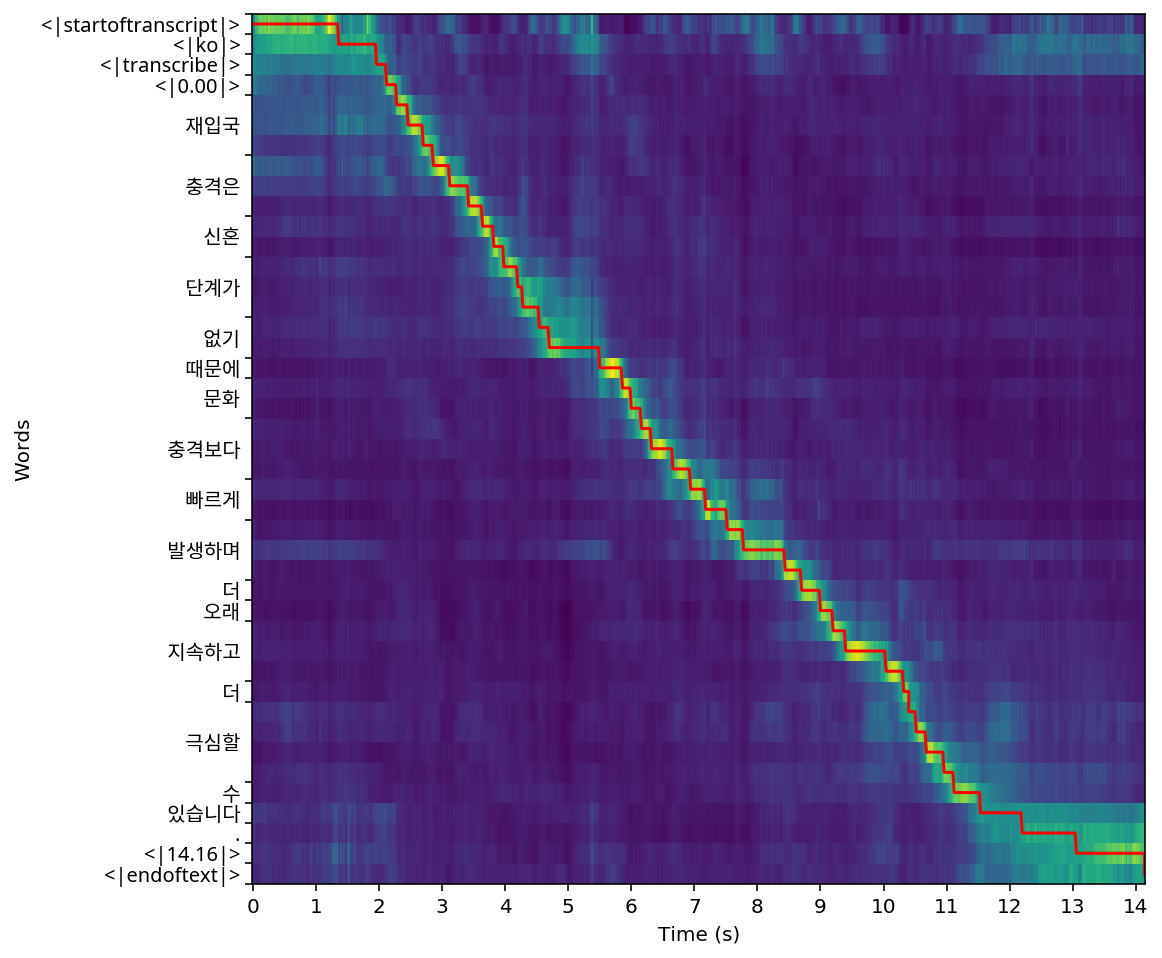

,word,begin,end
0,재입국,2.28,2.86
1,충격은,2.86,3.64
2,신혼,3.64,3.98
3,단계가,3.98,4.54
4,없기,4.54,5.50
5,때문에,5.50,5.86
6,문화,5.86,6.16
7,충격보다,6.16,6.94
8,빠르게,6.94,7.52
9,발생하며,7.52,8.70


 불행히도 운전자의 행동이 100% 확실하다고 예측할 수 없기 때문에 교통 흐름을 연구하기란 어렵다.


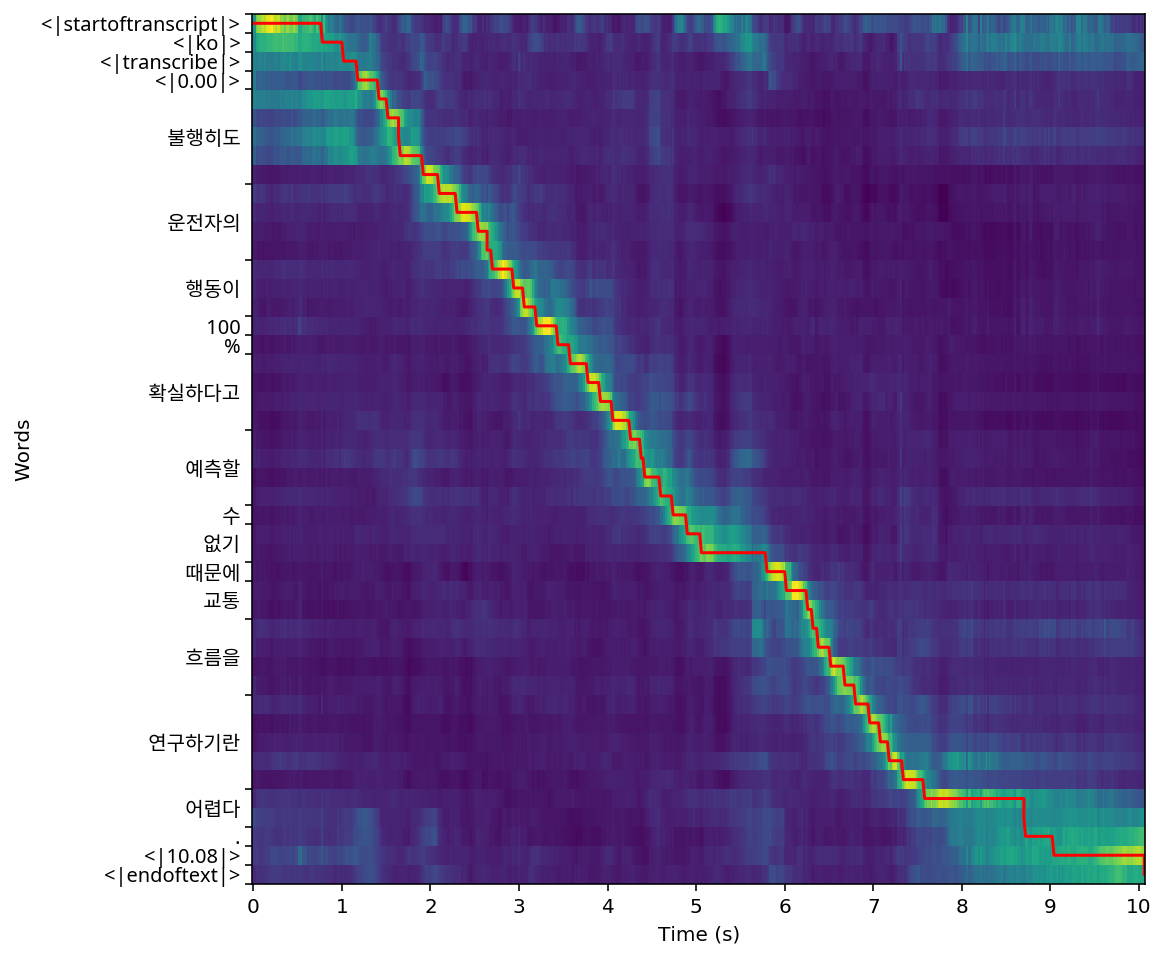

,word,begin,end
0,불행히도,1.42,2.10
1,운전자의,2.10,2.70
2,행동이,2.70,3.20
3,100,3.20,3.44
4,%,3.44,3.58
5,확실하다고,3.58,4.26
6,예측할,4.26,4.74
7,수,4.74,4.90
8,없기,4.90,5.80
9,때문에,5.80,6.02


 합금은 기본적으로 금속 2개 이상의 혼합물이다. 주기율표상의 원소가 많이 있다는 것을 잊지 마라.


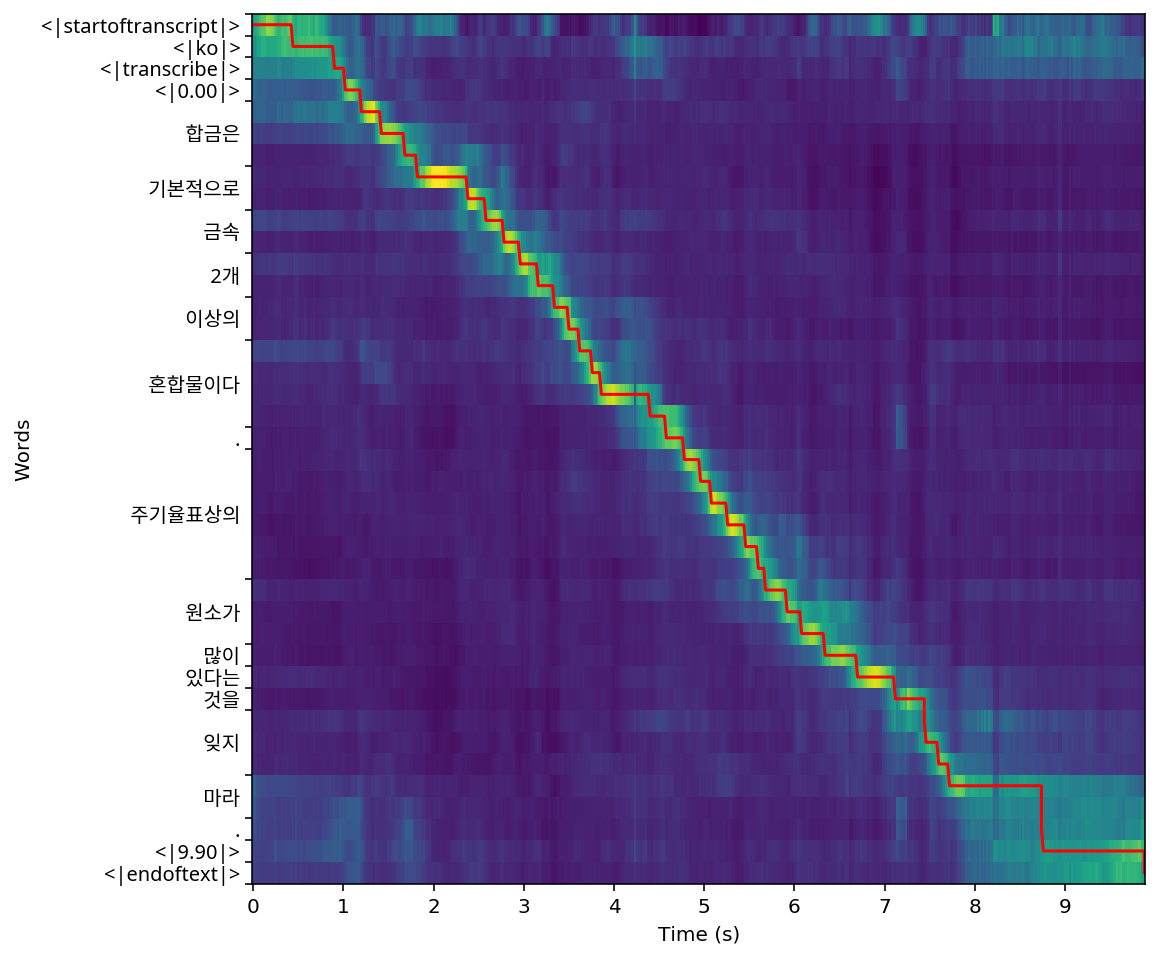

,word,begin,end
0,합금은,1.20,1.82
1,기본적으로,1.82,2.58
2,금속,2.58,2.96
3,2개,2.96,3.34
4,이상의,3.34,3.62
5,혼합물이다,3.62,4.58
6,주기율표상의,4.78,5.68
7,원소가,5.68,6.34
8,많이,6.34,6.70
9,있다는,6.70,7.12


 홍콩섬은 홍콩 영토에 홍콩이라는 이름을 부여한 곳이자 많은 관광객들이 주한점으로 여기는 곳이다.


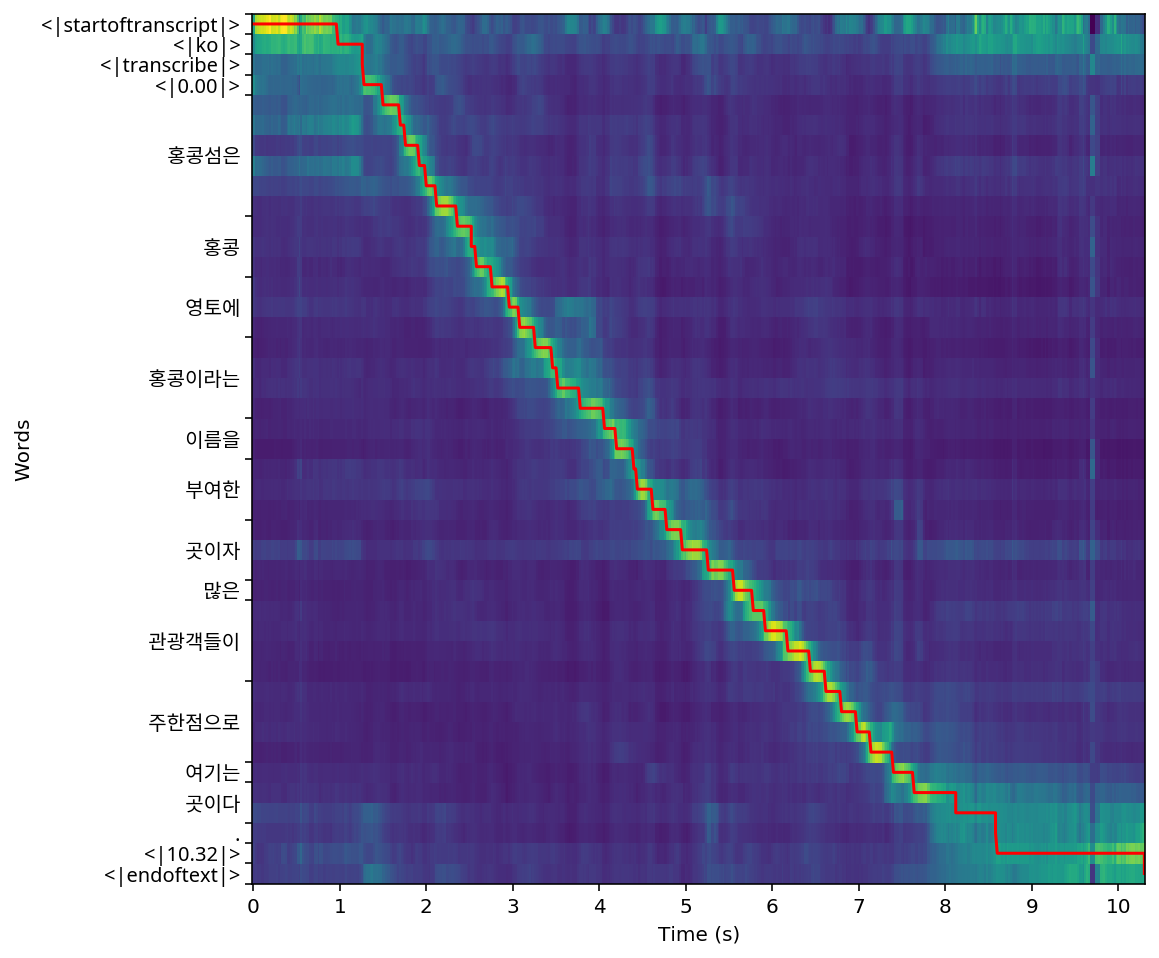

,word,begin,end
0,홍콩섬은,1.50,2.36
1,홍콩,2.36,2.76
2,영토에,2.76,3.26
3,홍콩이라는,3.26,4.06
4,이름을,4.06,4.40
5,부여한,4.40,4.78
6,곳이자,4.78,5.56
7,많은,5.56,5.78
8,관광객들이,5.78,6.62
9,주한점으로,6.62,7.40


 남자들을 단호히 거절하고 자신의 입장을 고수하는 것을 두려워하지 말라. 문화적 차이든 아니든 희롱은 간과 될 수 없다.


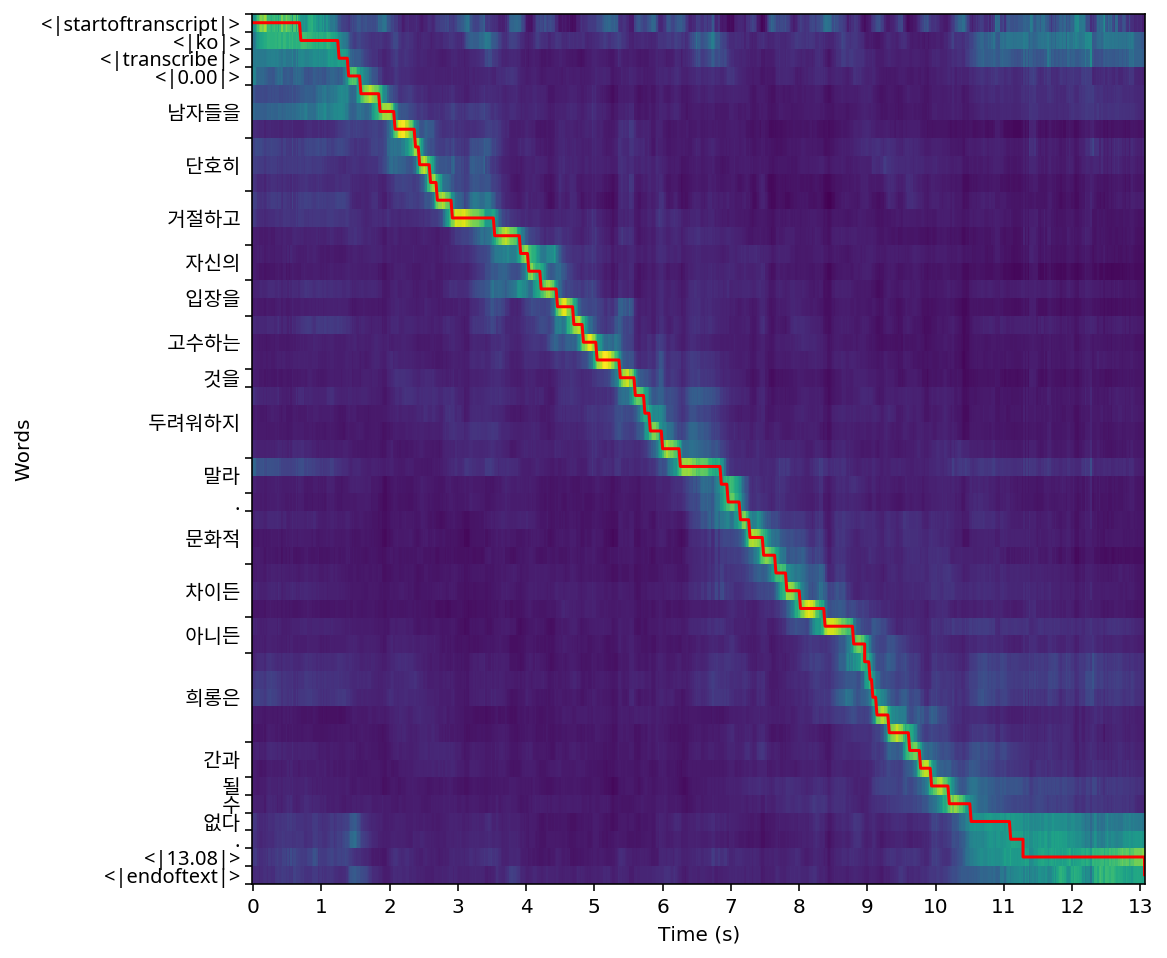

,word,begin,end
0,남자들을,1.58,2.38
1,단호히,2.38,2.70
2,거절하고,2.70,3.92
3,자신의,3.92,4.22
4,입장을,4.22,4.70
5,고수하는,4.70,5.38
6,것을,5.38,5.60
7,두려워하지,5.60,6.26
8,말라,6.26,6.96
9,문화적,7.14,7.66


 좀더 작은 섬의 대부분은 독립국가이거나 프랑스와 관련이 있고, 호화로운 비치 리조트로 알려져 있다.


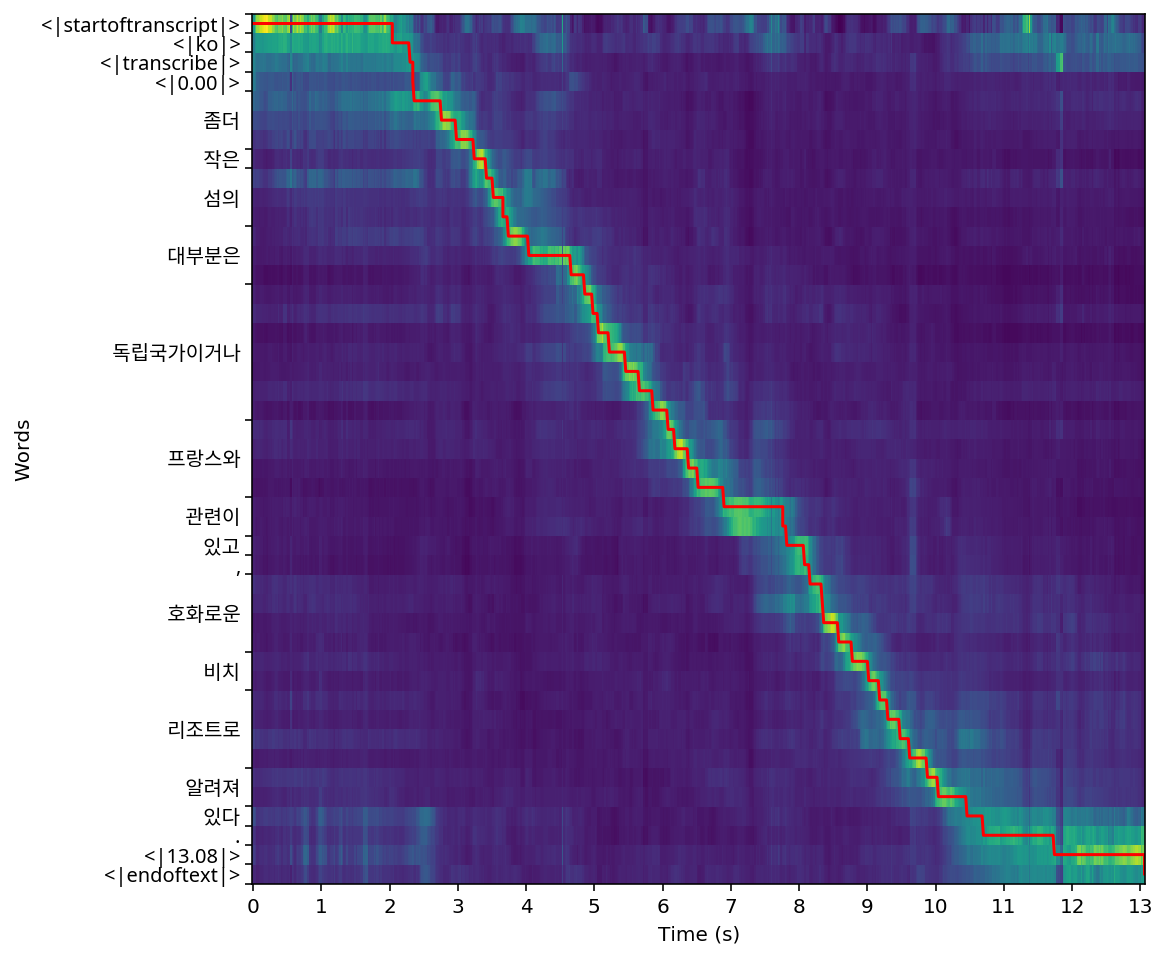

,word,begin,end
0,좀더,2.36,3.24
1,작은,3.24,3.42
2,섬의,3.42,3.74
3,대부분은,3.74,4.86
4,독립국가이거나,4.86,6.08
5,프랑스와,6.08,6.90
6,관련이,6.90,7.82
7,있고,7.82,8.08
8,호화로운,8.16,8.78
9,비치,8.78,9.18


 사실 이게 존재한다는 사실을 아는 사람이 있다고 해도 찾는 것조차 쉽지 않습니다. 일단 동굴 안에 들어가면 완전한 고립입니다.


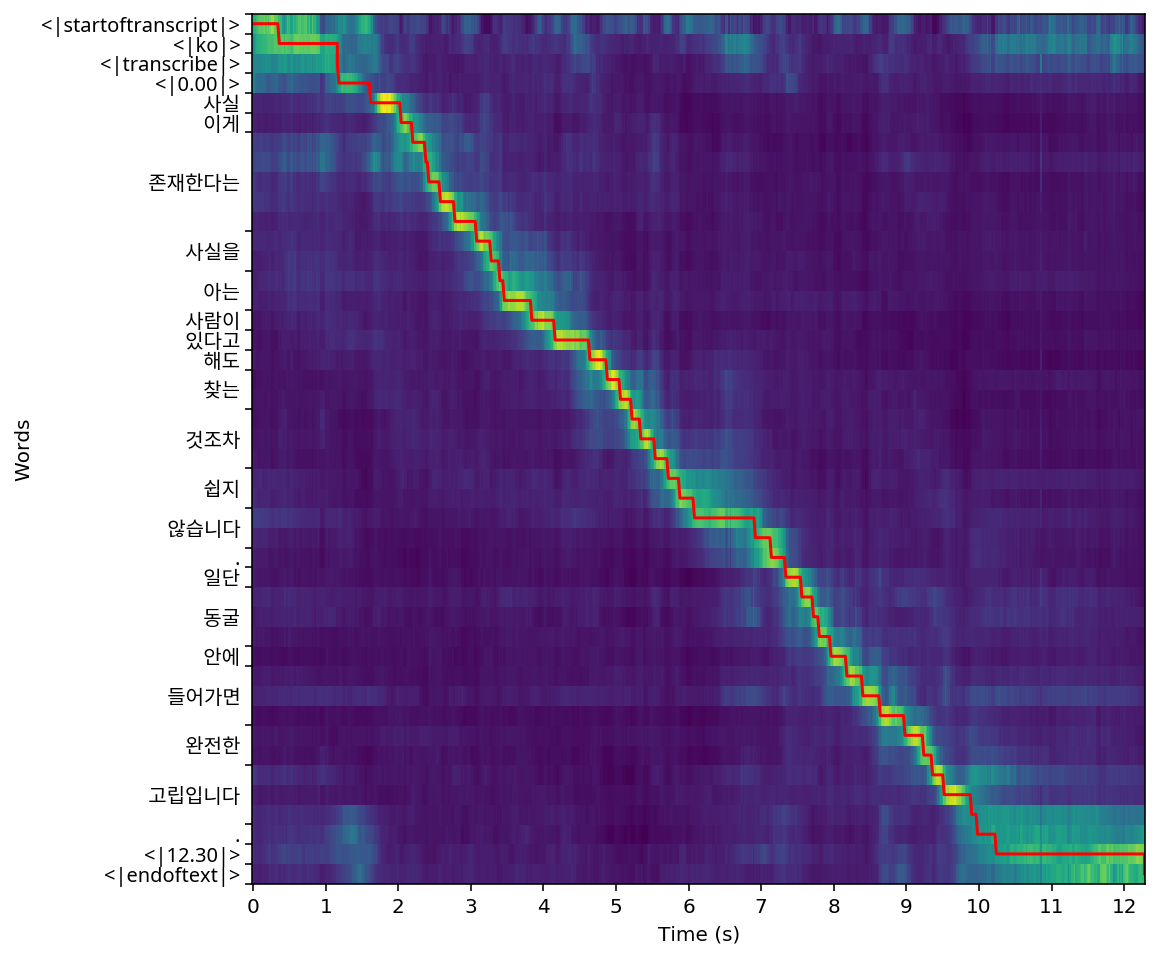

,word,begin,end
0,사실,1.62,2.04
1,이게,2.04,2.20
2,존재한다는,2.20,3.08
3,사실을,3.08,3.40
4,아는,3.40,3.84
5,사람이,3.84,4.16
6,있다고,4.16,4.64
7,해도,4.64,4.88
8,찾는,4.88,5.22
9,것조차,5.22,5.72


 원단이 너무 뜨거워지지 않도록 주의하세요. 원단이 수축하거나 그을릴 수 있습니다.


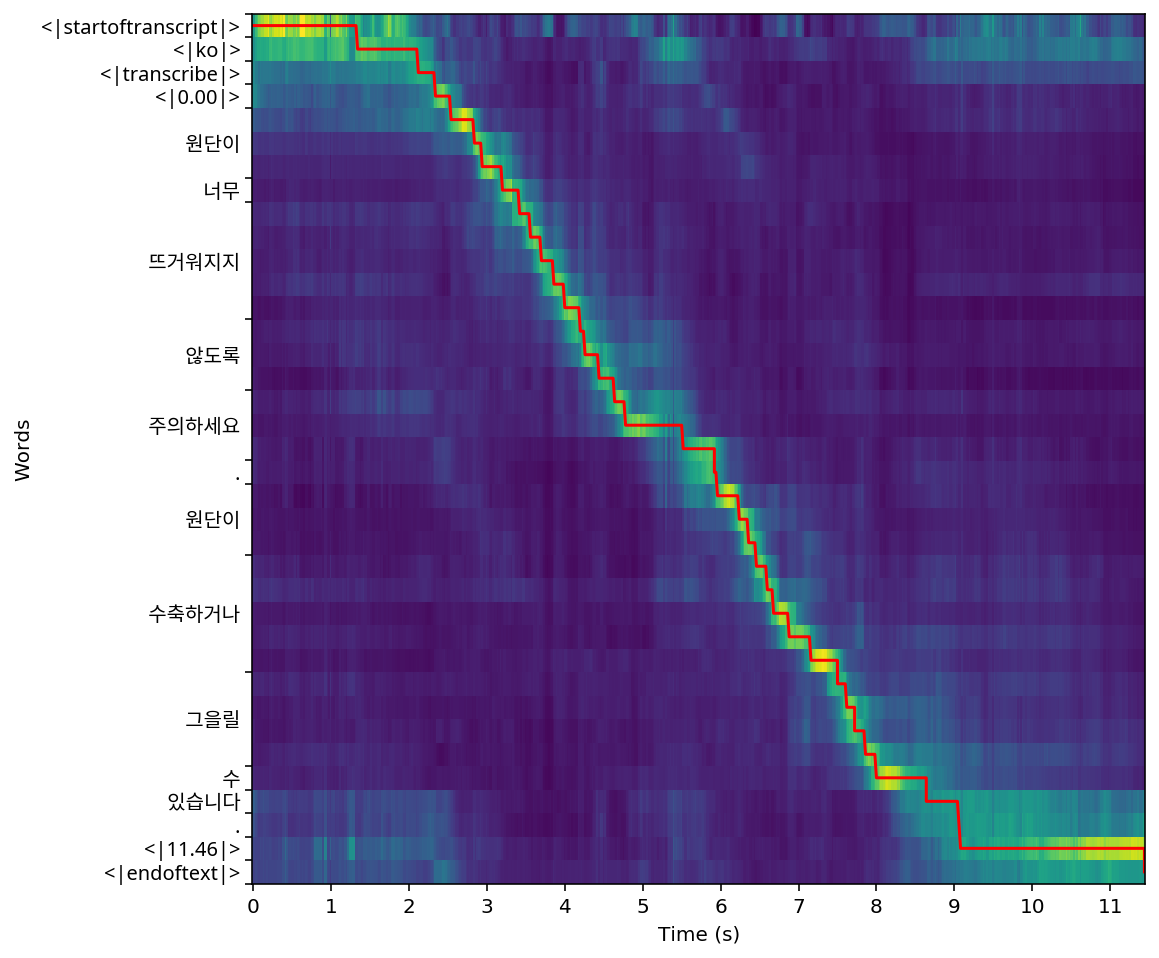

,word,begin,end
0,원단이,2.54,3.20
1,너무,3.20,3.42
2,뜨거워지지,3.42,4.20
3,않도록,4.20,4.64
4,주의하세요,4.64,5.92
5,원단이,5.96,6.46
6,수축하거나,6.46,7.50
7,그을릴,7.50,8.00
8,수,8.00,8.64
9,있습니다,8.64,9.06


 도널드 트럼프 미국 대통령은 늦은 일요일 시간대에 대변인을 통해 발표한 성명에서 미군이 시리아에서 철수할 것이라고 발표했다.


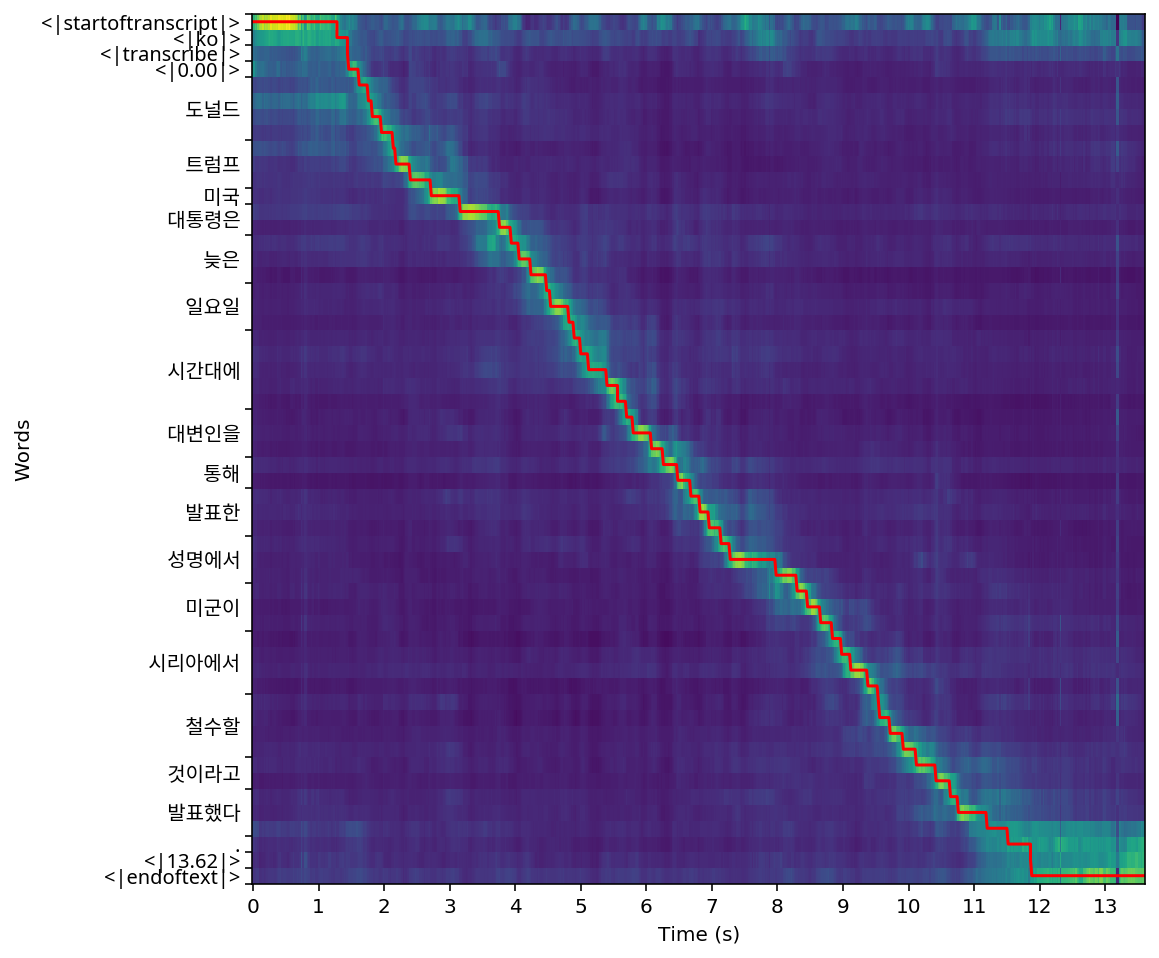

,word,begin,end
0,도널드,1.62,2.14
1,트럼프,2.14,2.72
2,미국,2.72,3.16
3,대통령은,3.16,3.94
4,늦은,3.94,4.48
5,일요일,4.48,4.90
6,시간대에,4.90,5.70
7,대변인을,5.70,6.26
8,통해,6.26,6.68
9,발표한,6.68,7.14


 미국 체조협회는 미국 올림픽위원회의 서한을 지지하며 미국의 전 운동선수가 안전한 환경을 가질 수 있도록 돕는 올림픽 관계자의 절대적 필요성을 인정합니다.


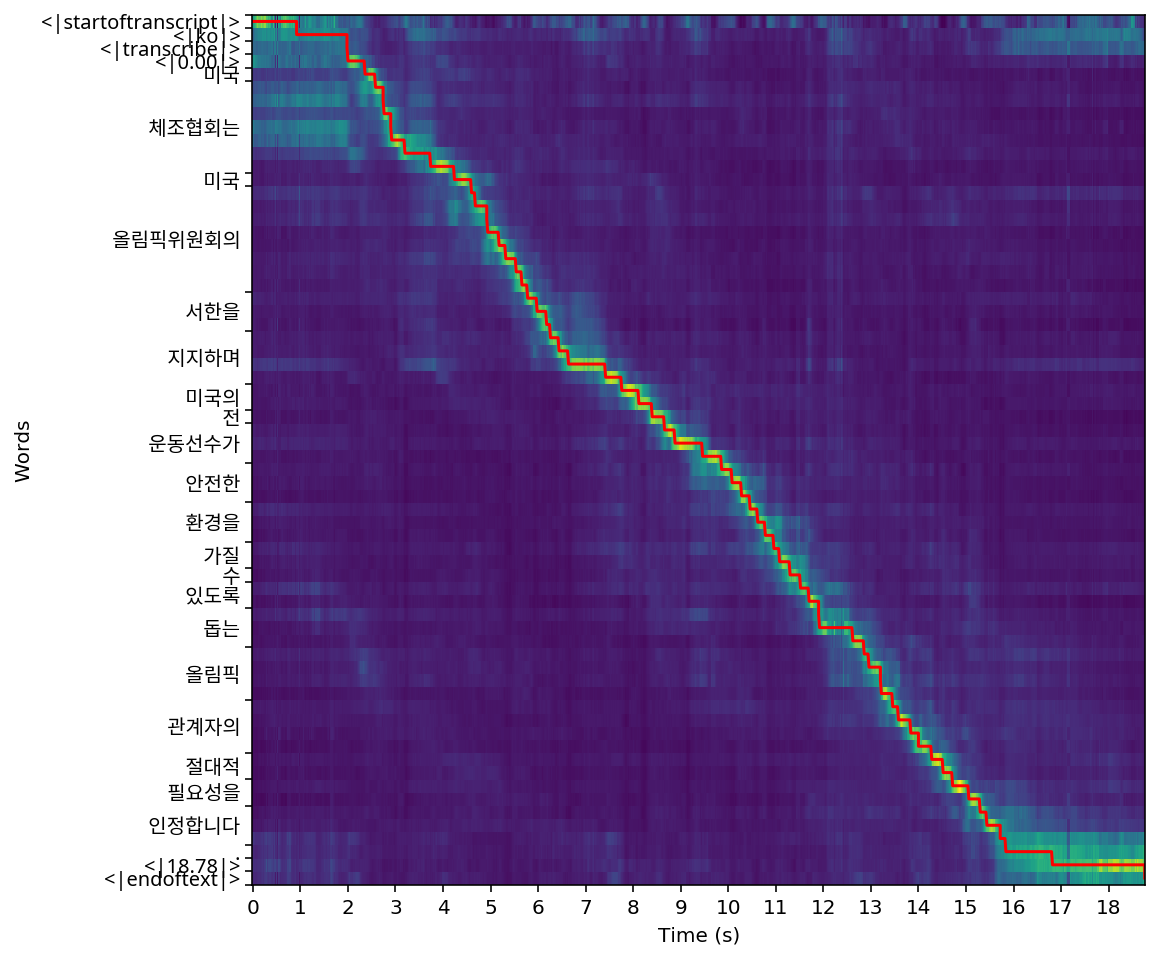

,word,begin,end
0,미국,2.36,2.58
1,체조협회는,2.58,4.24
2,미국,4.24,4.60
3,올림픽위원회의,4.60,5.78
4,서한을,5.78,6.26
5,지지하며,6.26,7.76
6,미국의,7.76,8.40
7,전,8.40,8.66
8,운동선수가,8.66,9.86
9,안전한,9.86,10.46


In [21]:
# for the first 10 examples in the dataset
for (audio, label), transcription in zip(dataset, transcriptions[:10]):
    print(transcription)
  
    duration = len(audio)
    mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(audio)).cuda()
    tokens = torch.tensor(
        [
            *tokenizer.sot_sequence,
            tokenizer.timestamp_begin,
        ] + tokenizer.encode(transcription) + [
            tokenizer.timestamp_begin + duration // AUDIO_SAMPLES_PER_TOKEN,
            tokenizer.eot,
        ]
    ).cuda()
    with torch.no_grad():
        logits = model(mel.unsqueeze(0), tokens.unsqueeze(0))

    weights = torch.cat(QKs)  # layers * heads * tokens * frames    
    weights = weights[:, :, :, : duration // AUDIO_SAMPLES_PER_TOKEN].cpu()
    weights = median_filter(weights, (1, 1, 1, medfilt_width))
    weights = torch.tensor(weights * qk_scale).softmax(dim=-1)
    
    w = weights / weights.norm(dim=-2, keepdim=True)
    matrix = w[-6:].mean(axis=(0, 1))

    alignment = dtw(-matrix.double().numpy())

    jumps = np.pad(np.diff(alignment.index1s), (1, 0), constant_values=1).astype(bool)
    jump_times = alignment.index2s[jumps] * AUDIO_TIME_PER_TOKEN
    words, word_tokens = split_tokens(tokens)

    # display the normalized attention weights and the alignment
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, aspect="auto")
    plt.plot(alignment.index2s, alignment.index1s, color="red")

    xticks = np.arange(0, matrix.shape[1], 1 / AUDIO_TIME_PER_TOKEN)
    xticklabels = (xticks * AUDIO_TIME_PER_TOKEN).round().astype(np.int32) 
    plt.xticks(xticks, xticklabels)
    plt.xlabel("Time (s)")
    
    # display tokens and words as tick labels
    ylims = plt.gca().get_ylim()

    ax = plt.gca()
    ax.tick_params('both', length=0, width=0, which='minor', pad=6)

    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.invert_yaxis()
    ax.set_ylim(ylims)

    major_ticks = [-0.5]
    minor_ticks = []
    current_y = 0
    
    for word, word_token in zip(words, word_tokens):
        minor_ticks.append(current_y + len(word_token) / 2 - 0.5)
        current_y += len(word_token)
        major_ticks.append(current_y - 0.5)
        
    ax.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(words))
    ax.set_yticks(major_ticks)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    for label in ax.get_yminorticklabels():
        label.set_fontproperties(prop)

    plt.ylabel("Words")
    plt.show()

    # display the word-level timestamps in a table
    word_boundaries = np.pad(np.cumsum([len(t) for t in word_tokens[:-1]]), (1, 0))
    begin_times = jump_times[word_boundaries[:-1]]
    end_times = jump_times[word_boundaries[1:]]

    data = [
        dict(word=word, begin=begin, end=end)
        for word, begin, end in zip(words[:-1], begin_times, end_times)
        if not word.startswith("<|") and word.strip() not in ".,!?、。"
    ]

    display(pd.DataFrame(data))
    display(HTML("<hr>"))